# <center style='color:lightcoral'> Classify `dogs` images using pretrained `EfficientNetV2L` with PyTorch </center>

## 1. Import the libraries

In [28]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [30]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA available: False
GPU: CPU


In [31]:
import torch
print(torch.version.cuda)  # Shows CUDA version PyTorch is built with
print(torch.cuda.is_available())  # Should return True

12.4
False


In [32]:
!pip install torchinfo # install the missing package, torchinfo

In [33]:
!pip install datasets

In [1]:
!pip install tensorflow tensorflow-datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt

## 2. Define the device

In [3]:
print('PyTorch version:', torch.__version__, '\n')
print('Torchvision version:', torchvision.__version__, '\n')

#print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.6.0+cu124 

Torchvision version: 0.21.0+cu124 

Device is: cpu 

Total number of GPUs: 0


## 3. Apply transformation

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load Stanford Dogs dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label)
    with_info=True,
)

print("Number of training samples:", ds_info.splits["train"].num_examples)
print("Features:", ds_info.features)

Number of training samples: 12000
Features: FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})


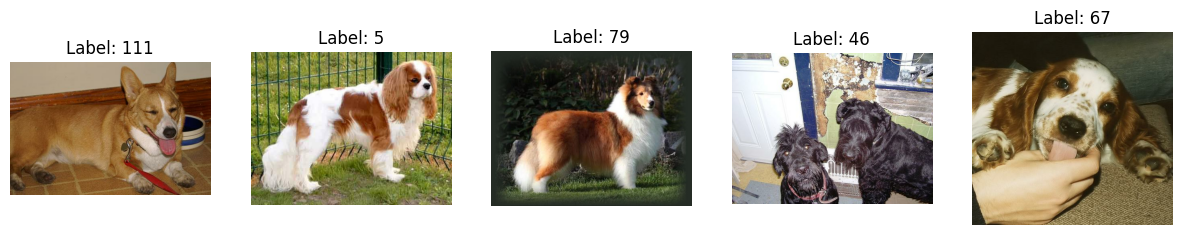

In [5]:
def show_images(dataset, num=5):
    plt.figure(figsize=(15, 5))
    for i, (image, label) in enumerate(dataset.take(num)):
        ax = plt.subplot(1, num, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
    plt.show()

show_images(ds_train)

## 4. Load `dogs` dataset

In [6]:
IMG_SIZE = 224  # EfficientNet expected input size

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

batch_size = 32

train_ds = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Load model with ImageNet weights
model = EfficientNetB0(weights='imagenet', include_top=True)

# Predict on one sample
for images, labels in train_ds.take(1):
    predictions = model.predict(images)
    top_pred = tf.argmax(predictions[0]).numpy()
    print("Predicted class index:", top_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class index: 644


In [8]:
# check the length of training and test datasets

print('Length of the training dataset:', len(train_ds))
print('Length of the test dataset:', len(test_ds))

Length of the training dataset: 300
Length of the test dataset: 75


Shape: (total images, height, width, channels)

#### The `spatial dimension` of the `color images` in the `CIFAR100 dataset` is `32x32` pixels.

In [9]:
# Load the Stanford Dogs dataset
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label)
    with_info=True,
)

classes = ds_info.features['label'].names

Visualize train samples

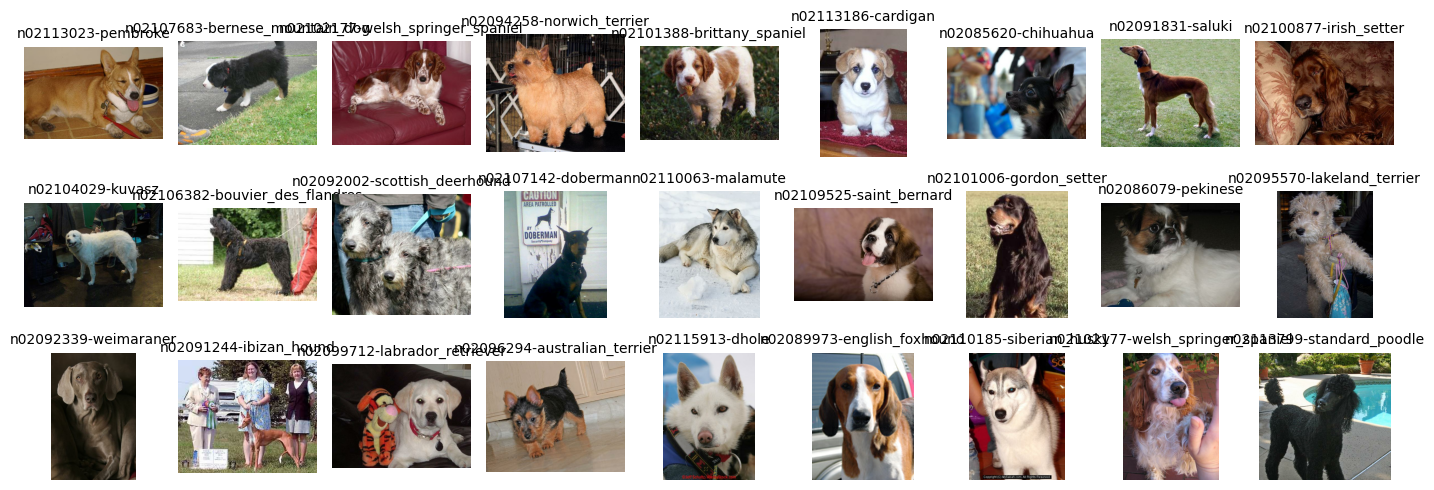

In [10]:
# Load one sample at a time to avoid memory overload
fig, axis = plt.subplots(nrows=3, ncols=9, figsize=(14, 5))

# Convert the _PrefetchDataset to a list to enable indexing
ds_train_list = list(ds_train)

for ax in axis.ravel():
    idx = np.random.randint(len(ds_train_list))  # Use the length of the list
    image, label = ds_train_list[idx]  # Index the list

    # If image is a tensor, convert to numpy and move channel to last
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).numpy()
        # Undo normalization if necessary
        image = (image * 0.5) + 0.5  # Assuming normalization was mean=0.5, std=0.5

    ax.imshow(image)
    ax.set_title(classes[label], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

Visualize test samples

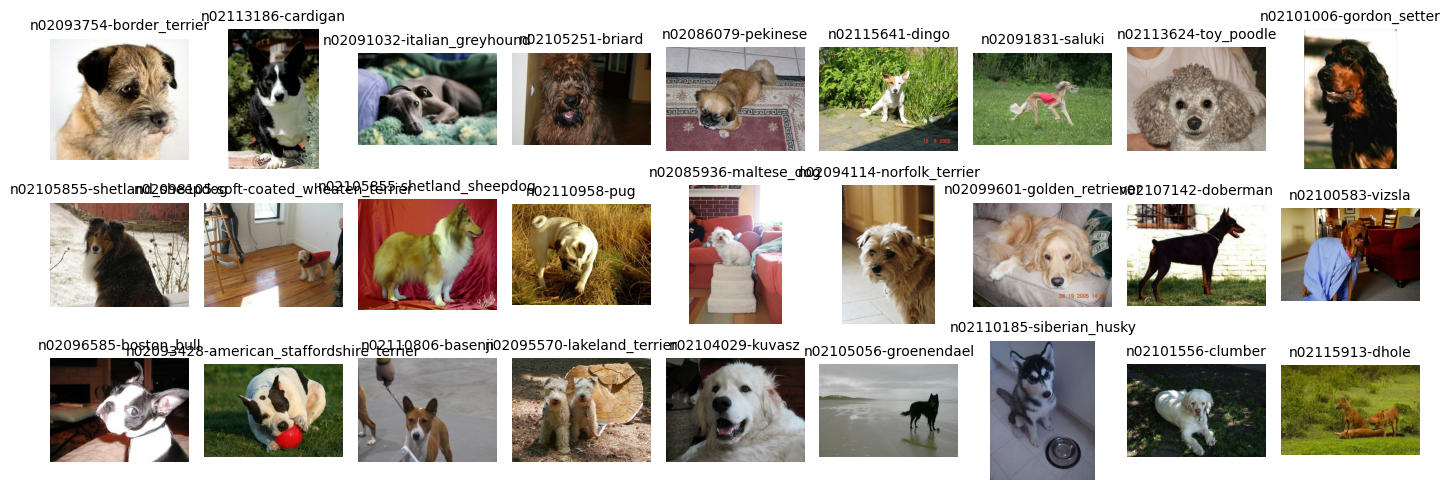

In [11]:
fig, axis = plt.subplots(nrows=3, ncols=9, figsize=(14, 5))

# Convert the _PrefetchDataset to a list to enable indexing
ds_test_list = list(ds_test)  # Convert to a list

for ax in axis.ravel():
    idx = np.random.randint(len(ds_test_list))  # Use the length of the list
    image, label = ds_test_list[idx]  # Index the list

    # If image is a tensor, convert to numpy and move channels for imshow
    if torch.is_tensor(image):
        image = image.permute(1, 2, 0).numpy()
        # Undo normalization (assuming mean=0.5, std=0.5 as used in transforms)
        image = (image * 0.5) + 0.5
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.set_title(classes[label], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 5. Define dataloaders

In [12]:
import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

IMG_SIZE = 224
preprocess = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing to datasets (train and test)
def preprocess_dataset(dataset):
    images, labels = [], []
    for image, label in tfds.as_numpy(dataset):  # Iterate through dataset using tfds.as_numpy
        # Convert image to PIL Image before applying transforms
        image = Image.fromarray(image)
        image = preprocess(image)
        images.append(image)
        labels.append(label)
    return TensorDataset(torch.stack(images), torch.tensor(labels))

from torch.utils.data import Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

In [ ]:
class LazyImageDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = list(hf_dataset)  # Convert _PrefetchDataset to list
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(Image.fromarray(image.numpy()))  # Convert Tensor to PIL Image

        return image, label

train_dataset = LazyImageDataset(ds_train, transform=transform)
test_dataset = LazyImageDataset(ds_test, transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print('Length of the training dataloader:', len(train_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

#### Dataloader converts a dataset into an iterable.

## 6. The pretrained network (`EfficientNetV2L`) architecture

In [ ]:
EfficientNetV2L = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:11<00:00, 41.9MB/s]


## 7. Visualize the pretrained model (`VGG16`) architecture

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1).to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

# Access model parameters
print(f"Number of model parameters: {sum(p.numel() for p in model.parameters())}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
   StochasticDepth-7         [-1, 32, 112, 112]               0
       FusedMBConv-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           9,216
      BatchNorm2d-10         [-1, 32, 112, 112]              64
             SiLU-11         [-1, 32, 112, 112]               0
  StochasticDepth-12         [-1, 32, 112, 112]               0
      FusedMBConv-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 32, 1

## 8. Modified pretrained network (`modified_EfficientNetV2L`) architecture for `CIFAR100` images

In [ ]:
modified_EfficientNetV2L = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)
for param in modified_EfficientNetV2L.parameters():
    param.requires_grad = False

modified_EfficientNetV2L.classifier = nn.Sequential()
modified_EfficientNetV2L.classifier.add_module('dropout1', nn.Dropout(p=0.4, inplace=True))
modified_EfficientNetV2L.classifier.add_module('linear1', nn.Linear(in_features=1280, out_features=1000))
modified_EfficientNetV2L.classifier.add_module('dropout2', nn.Dropout(p=0.4, inplace=True))
modified_EfficientNetV2L.classifier.add_module('linear2', nn.Linear(in_features=1000, out_features=100))

## 9. Visualize the modified pretrained model (`modified_EfficientNetV2L`) architecture

In [ ]:
modified_model = modified_EfficientNetV2L.to(device)
summary(modified_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           9,216
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
   StochasticDepth-7         [-1, 32, 112, 112]               0
       FusedMBConv-8         [-1, 32, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           9,216
      BatchNorm2d-10         [-1, 32, 112, 112]              64
             SiLU-11         [-1, 32, 112, 112]               0
  StochasticDepth-12         [-1, 32, 112, 112]               0
      FusedMBConv-13         [-1, 32, 112, 112]               0
           Conv2d-14         [-1, 32, 1

In [ ]:
modified_model.parameters

<bound method Module.parameters of EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.002531645569620253, mode=row)
      )
      (2): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.005063291139240506, mode=row)
      )
      (3): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.007594936708860761, mode=row)
      )
    )
    (2): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.010126582278481013, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.012658227848101266, mode=row)
      )
      (2): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.015189873417721522, 

## 10. Define the training batch

In [ ]:
def training_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

## 11. Define the test batch

In [ ]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

## 12. Define the accuracy function

In [ ]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

## 13. Set up model_to_train (`modified_EfficientNetV2L`), criterion (`loss function`) and optimizer

In [ ]:
model_to_train = modified_EfficientNetV2L.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_to_train.parameters(), lr=0.01)

## 14. Train the model

In [ ]:
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

n_epochs = 25

training_loss, test_loss = [], []
training_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    training_losses, test_losses = [], []
    training_accuracies, test_accuracies = [], []

    for data, labels in train_dataloader:
        trng_batch_loss = training_batch(data, labels, model_to_train, criterion, optimizer)
        training_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, model_to_train)
        training_accuracies.extend(trng_batch_correct)
    training_per_epoch_loss = np.array(training_losses).mean()
    training_per_epoch_accuracy = np.mean(training_accuracies)

    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, model_to_train, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, model_to_train)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)

    training_loss.append(training_per_epoch_loss)
    training_accuracy.append(training_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)

    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} | ', end='')
    print(f'Training accuracy: {training_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
    print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "<ipython-input-14-5ba1c818a0c0>", line 18, in __getitem__
    example = self.dataset[idx]
              ~~~~~~~~~~~~^^^^^
TypeError: '_PrefetchDataset' object is not subscriptable


## 15. Plot model loss and accuracy

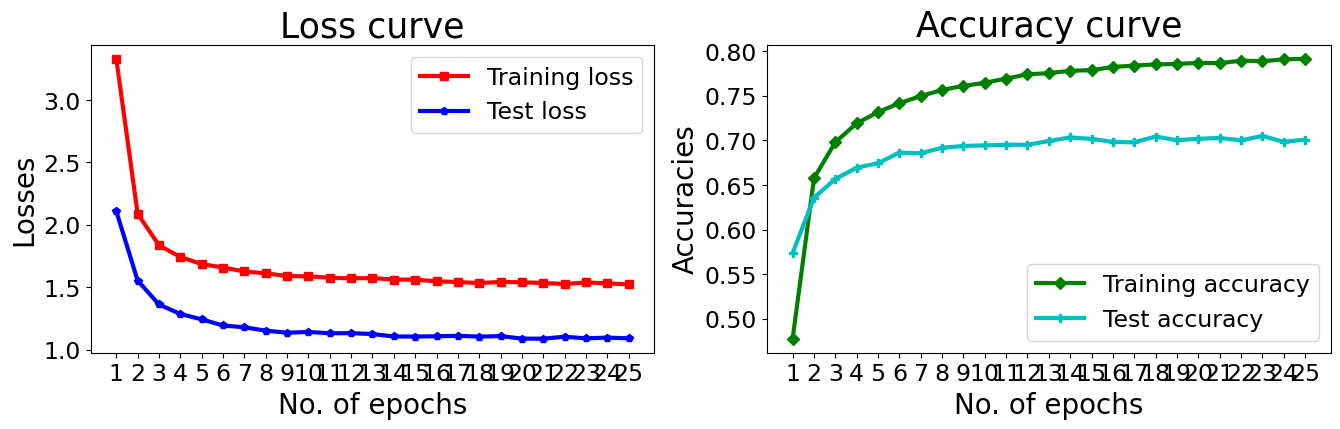

In [ ]:
N = np.arange(n_epochs) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, training_loss, 'r-s', linewidth=3, label='Training loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks(N, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, training_accuracy, 'g-D', linewidth=3, label='Training accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks(N, fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

## 16. Model prediction

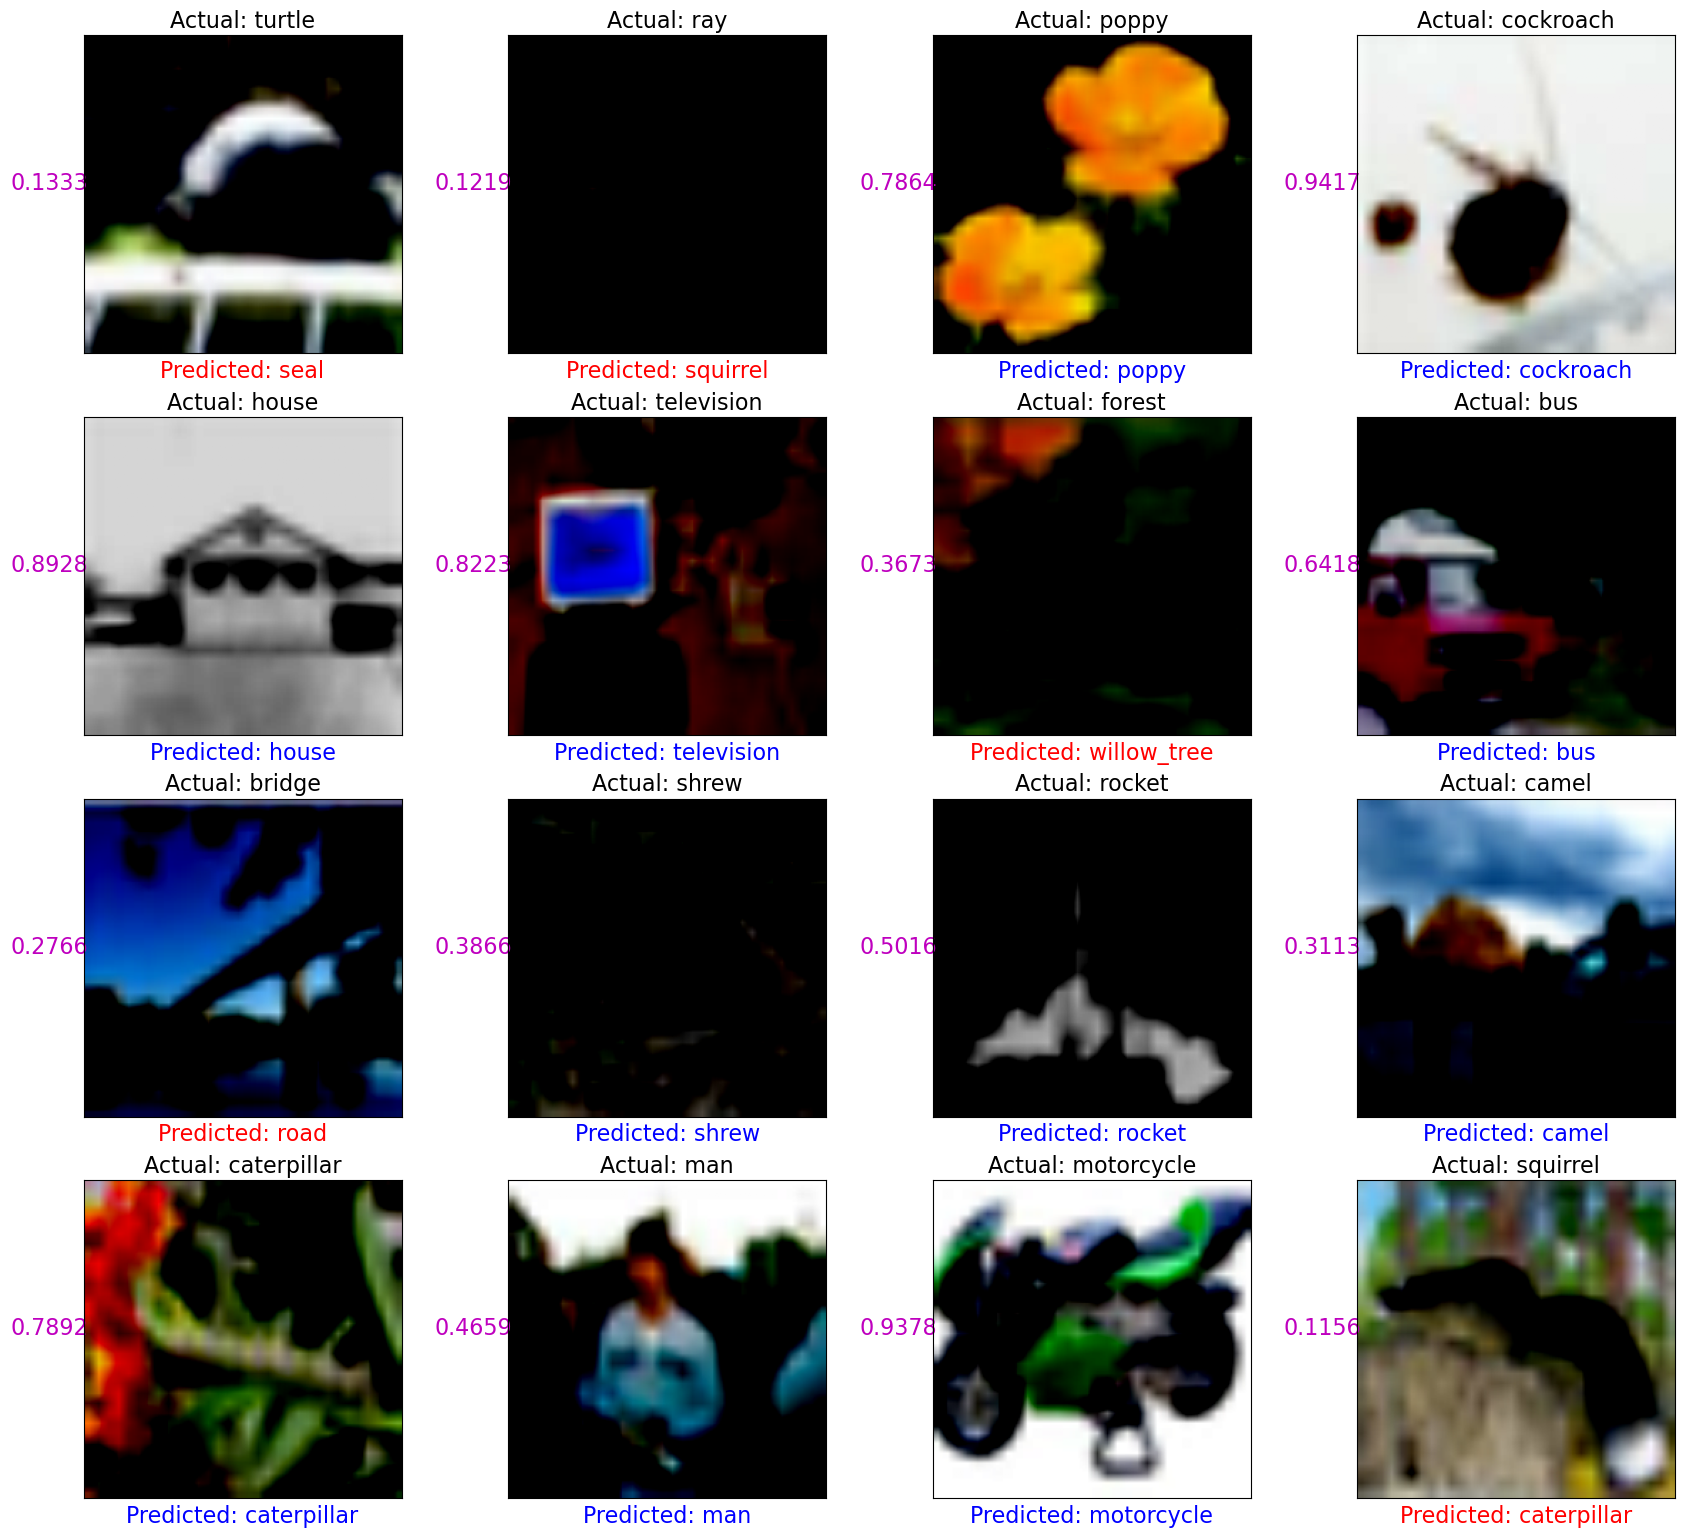

In [ ]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(16):
    idx = np.random.randint(len(test_dataset))
    SAMPLES.append(test_dataset[idx])
    output = F.softmax(model_to_train.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(21, 19))
i = 0
for R in range(4):
    for C in range(4):
        ax[R, C].imshow(torch.clamp(SAMPLES[i][0], min=0, max=1).permute(1, 2, 0))
        ax[R, C].set_title('Actual: ' + classes[SAMPLES[i][1]], fontsize=16).set_color('k') # actual labels
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('b') # correctly predicted labels
        else:
            ax[R, C].set_xlabel('Predicted: ' + classes[LABELS[i]], fontsize=16).set_color('r') # wrongly predicted labels
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=25).set_color('m') # probability of predicted class
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1


# <center style='color:lightcoral'> Comparison between EfficientNetV2 and MobileNetV3 </center>

Overview

| Feature                | **EfficientNetV2**                                  | **MobileNetV3**                                      |
|------------------------|------------------------------------------------------|------------------------------------------------------|
| **Introduced By**     | Google (2021)                                       | Google (2019)                                       |
| **Architecture Type** | Compound scaling CNN                                | Lightweight CNN with NAS & SE modules               |
| **Optimization**      | Training speed & parameter efficiency               | Latency & mobile deployment                         |
| **Variants**          | EfficientNetV2-S, -M, -L, etc.                      | MobileNetV3-Small, MobileNetV3-Large                |

---

| **Feature**                  | **EfficientNetV2L (CIFAR-100)**                    | **MobileNetV3 (Brain Tumor Detection)**               |
|-----------------------------|----------------------------------------------------|--------------------------------------------------------|
| **Model**                   | EfficientNetV2L                                     | MobileNetV3 (Large)                                    |
| **Pretrained**              | ✅ Yes (on ImageNet)                                | ✅ Possibly (on ImageNet or fine-tuned on medical data)|
| **Dataset**                 | CIFAR-100                                          | Brain Tumor Detection Dataset                          |
| **Image Size**              | 32×32                                              | Likely higher-resolution MRI/CT images                 |
| **Task Type**               | Multi-class (100 classes)                         | Binary or low-class-count (2–4 classes)                |
| **Reported Accuracy**       | ~79%                                               | ~90%                                                   |
| **Model Size (Params)**     | ~118M                                              | ~5.4M                                                  |
| **Architecture Type**       | Deep CNN with fused MBConv & SE blocks             | Lightweight CNN with NAS, SE blocks                    |
| **Training Difficulty**     | High (more classes, smaller images)                | Medium (often fewer classes, clearer patterns)         |
| **Inference Speed**         | Slower (heavy model)                               | Fast (optimized for mobile/edge devices)               |

---

Contextual Comparison

| **Aspect**                    | **Explanation**                                                                                             |
|------------------------------|-------------------------------------------------------------------------------------------------------------|
| **Accuracy Comparison**      | 90% > 79% numerically, but CIFAR-100 is far harder (100 classes vs. 2–4).                                   |
| **Dataset Complexity**       | CIFAR-100: low-res, cluttered, natural images. <br> Brain tumors: higher res, often grayscale, domain-specific. |
| **Model Objective**          | EfficientNetV2L: maximize accuracy across diverse datasets. <br> MobileNetV3: balance accuracy with speed.  |
| **Overfitting Risk**         | Lower on CIFAR-100 (large dataset). <br> Higher on medical datasets (smaller size, class imbalance).        |

---

> 📝 **Note:** EfficientNetV2 is optimized for **training efficiency and accuracy**, while MobileNetV3 is optimized for **low latency inference on mobile devices**.

---

Use Case Suitability

| Use Case                       | EfficientNetV2                        | MobileNetV3                          |
|--------------------------------|----------------------------------------|--------------------------------------|
| **Mobile Apps**               | ❌ Less suitable (heavier)            | ✅ Highly suitable                   |
| **Cloud-based Classification**| ✅ Excellent performance               | ✅ Still decent if resources limited |
| **Real-time Applications**    | ⚠️ Possible with smaller versions      | ✅ Preferred choice                  |
| **Embedded Systems**          | ❌ Too large for microcontrollers     | ✅ Designed for this use case        |

---

Summary

| **Category**              | **EfficientNetV2**                                     | **MobileNetV3**                       
|---------------------------|--------------------------------------------------------|--------------------------------------
| Best For                  | Accuracy-focused models, cloud training                | Edge devices, mobile, fast inference             
| Tradeoff                  | More accurate, but slower and heavier                 | Lighter, but lower accuracy                      
| Ideal Environment         | Server/cloud deployment                               | Mobile/IoT devices                               

---

Conclusion

- **Use EfficientNetV2** when:
  - Accuracy is more important than latency.
  - You have access to GPUs/TPUs.
  - You're training in the cloud.

- **Use MobileNetV3** when:
  - You need real-time inference.
  - You're deploying to mobile or edge devices.
  - Latency and power efficiency are top priorities.